In [ ]:
!pip install flaml[blendsearch]

In [73]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
import pandas as pd
from flaml import tune
import time
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [5]:
new = pd.read_excel('ml.xlsx')

In [74]:
df = new

In [75]:
df.head()

,Unnamed: 0,Район,Расстояние до метро,Стадия строительной готовности на дату договора,Срок ввода в эксплуатацию - Старт продаж,Класс,Девелопер,Срок ввода в эксплуатацию - Договор,Квартал договора,Тип сделки,...,Включение скидок/акций в ценообразование,Скидки по дате договора,Отделка по корпусу,Тип продавца,Тип покупателя,Кол-во покупателей,Тип ипотеки,Участие объекта в оптовой сделке,"Срок в экспозиции до момента сделки, дней",Рост цены за 1 кв.м за период экспонирования
0,0,0,15.10,5,1156,1,0,546,1,1,...,0,12,8,1,0,1,1,1,0,0.0
1,1,0,0.13,1,821,1,2,546,1,1,...,0,2,0,1,0,1,1,1,211,7.5
2,2,0,0.13,1,821,1,2,546,1,1,...,0,2,0,1,0,3,1,1,211,16.3
3,4,0,0.54,1,789,1,14,453,1,1,...,0,2,8,1,0,1,1,1,275,15.0
4,5,0,0.59,1,789,1,14,453,1,1,...,0,2,8,1,0,2,0,1,0,0.0


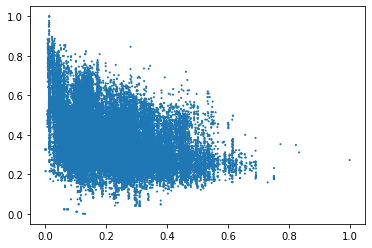

In [77]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['Цена за кв. метр']])
scaled1 = scaler.fit_transform(df[['Площадь согласно ПД']])
scaler = MinMaxScaler()
scaled = scaler.fit_transform(scaled)
scaled1 = scaler.fit_transform(scaled1)
s = [n**0.01 for n in range(len(df))]
plt.scatter(scaled1, scaled, s=s)

(28589.97, 340581.43) (-67.45, 1416.45)


<Figure size 400x200 with 0 Axes>

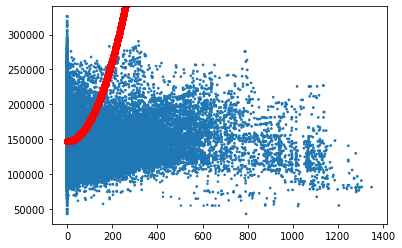

None


In [179]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
from matplotlib.pyplot import figure
figure(figsize=(4, 2), dpi=100)

clas=1
def objective(x, a, b, c):
    return a * x + b * x**2 + c
# df['Срок в экспозиции до момента сделки, дней']
s = [n**0.1 for n in range(len(df[df['Класс']==clas]))]
x = df[df['Класс']==clas]['Срок в экспозиции до момента сделки, дней']
y = df[df['Класс']==clas]['Цена за кв. метр']

popt, _ = curve_fit(objective, x, y)

a, b, c = popt
fit_equation = a * np.square(x) + b * x + c
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.scatter(x, y, s=s)
limx = (-67.45, 1416.45)
limy = (28589.97, 340581.43)
ax1.scatter(x, fit_equation, color = 'r')
ax1.set(ylim=limy, xlim=limx)
print(ax1.get_ylim(), ax1.get_xlim())
print(plt.show())

In [54]:
df[df['Площадь согласно ПД']==20]['Цена за кв. метр'].value_counts()scatter

210100.0    3
259200.0    3
209200.0    3
227459.0    3
175000.0    3
           ..
223300.0    1
229200.0    1
199000.0    1
239700.0    1
213600.0    1
Name: Цена за кв. метр, Length: 85, dtype: int64

In [8]:
[['Этаж', 'Площадь согласно ПД', 'Район', 'Класс', 'Расстояние до метро', 'Девелопер']]
y = df['Цена за кв. метр']
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
y_train

17172    116000.00
50450    154933.00
56014    151851.88
33315    146030.00
49560    189414.84
           ...    
54343    144488.50
38158     85472.00
860      105969.98
15795    136900.00
56422    220667.93
Name: Цена за кв. метр, Length: 39761, dtype: float64

In [10]:
# !pip install flaml[blendsearch]
# !pip install ray
# !pip install -U tensorboardx

In [11]:
def train(algo, config, start):

    def evaluate_config(config):
      algo.set_params(**config)
      algo.fit(X_train, y_train)
      y_pred = algo.predict(X_test)
      tune.report(metric=mean_absolute_error(y_test, y_pred))

    analysis = tune.run(
      evaluate_config,   
      config=config, 
      low_cost_partial_config = start,
      mode='min', 
      metric='metric',        
      num_samples=-1,    
      time_budget_s=450,  
      verbose=0,
      # use_ray=True 
      )

    print(analysis.best_trial.last_result['metric'])  # the best trial's result
    print(analysis.best_config) # the best config


In [12]:
ridge={ 'alpha': tune.quniform(0.0001, 1, 0.0000001),
        'tol': tune.qloguniform(1e-10, 1e-1, 1e-10),
        'solver': tune.choice({'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'})
    }
lasso={ 'alpha': tune.quniform(0.001, 1, 0.0001),
        'tol': tune.choice([1e-4, 1e-5, 1e-6, 1e-3, 1e-2]),
       'max_iter': tune.choice([1e6])
    }
tree = {
    'criterion': tune.choice(['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'splitter': tune.choice(['best', 'random']),
    'max_depth': tune.randint(10, 100),
    'min_samples_split': tune.randint(2, 5),
    'min_samples_leaf': tune.randint(2, 5),
    'max_features': tune.choice(['auto', 'sqrt', 'log2']),
    'random_state': tune.choice([42, None])
}
# train(DecisionTreeRegressor(), tree, {'splitter': 'best'})

0.9999835990868878
5.7441378404616866e-05


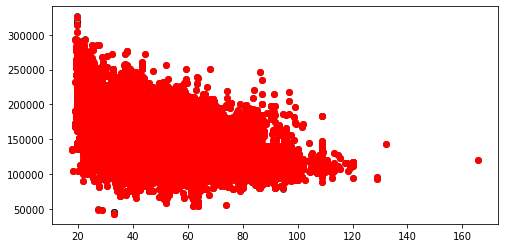

In [13]:
# reg = Lasso(**{'alpha': 0.001, 'tol': 0.01, 'max_iter': 1000000.0})
# 0.62 
reg = DecisionTreeRegressor()
# # 0.99 reg=DecisionTreeRegressor(**{'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'random_state': None})
# reg=DecisionTreeRegressor(**{'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'random_state': 42})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(r2_score(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X_test['Площадь согласно ПД'], y_test, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.scatter(X_test['Площадь согласно ПД'], y_pred, color='r', label='Regression model')
plt.show()

In [14]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       Цена за кв. метр   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.506e+32
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        19:23:07   Log-Likelihood:             1.3039e+06
No. Observations:               59346   AIC:                        -2.608e+06
Df Residuals:                   59317   BIC:                        -2.607e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------